<h1><strong><u>Naive Bayes Test (A4)</u></strong><h1>

In [8]:
import matplotlib.pyplot as plt            
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, PrecisionRecallDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbLearn_Pipeline

<h2><u>Data Loading and Preprocessing</u></h2>

In [9]:
pd.read_csv("./SMSSpamCollection.txt", sep="\t", header=None).to_csv("sms_spam_collection.csv", index=False, header=["target", "message"])

In [10]:
data = pd.read_csv("sms_spam_collection.csv")
data

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [11]:
X = data['message']
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(4457,)

(1115,)

(4457,)

(1115,)

In [12]:
#Display message counts
hams = data[(data['target'] == 'ham')]
spams = data[(data['target'] == 'spam')]
hams_count = hams.value_counts().sum()
spams_count = spams.value_counts().sum()
total_messages = hams_count + spams_count
spam_fraction = spams_count / total_messages

print("Number of ham messages: ", hams_count)
print("Number of spam messages: ", spams_count)
print("Fraction of spam messages: {:.2f}%".format(spam_fraction * 100))

Number of ham messages:  4825
Number of spam messages:  747
Fraction of spam messages: 13.41%


In [13]:
def custom_tokenizer(text):
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        import re
        en_stopwords = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        new_text = text.lower() #lowercase

        new_text = re.sub(r"([^\w\s])", "", new_text) #remove punctuation

        for word in new_text.split(): #remove stopwords
            if word in en_stopwords:
                new_text = new_text.replace(word, "")
        
        new_text = word_tokenize(new_text) #tokenize

        new_text = [lemmatizer.lemmatize(token) for token in new_text] #lemmatize
        return new_text

In [14]:
display(y_train.head())
display(y_test.head())

label_encoder = LabelEncoder()
y_train_transformed = label_encoder.fit_transform(y_train)
y_test_transformed = label_encoder.transform(y_test)

y_train_transformed = pd.Series(data=y_train_transformed, name='target')
y_test_transformed = pd.Series(data=y_test_transformed, name='target')
display(y_train_transformed.head(10))
display(y_test_transformed.head(20))

# store these in a variable instead of in place
y_train_transformed_rev = y_train_transformed.replace(to_replace=0, value=2)

y_train_transformed_rev.replace(to_replace=1, value=0, inplace=True)

y_train_transformed_rev.replace(to_replace=2, value=1, inplace=True)
display(y_train_transformed_rev.head(10))

y_test_transformed_rev = y_test_transformed.replace(to_replace=0, value=2)

y_test_transformed_rev.replace(to_replace=1, value=0, inplace=True)

y_test_transformed_rev.replace(to_replace=2, value=1, inplace=True)
display(y_test_transformed_rev.head(20))

1642    ham
2899    ham
480     ham
3485    ham
157     ham
Name: target, dtype: object

1078    ham
4028    ham
958     ham
4642    ham
4674    ham
Name: target, dtype: object

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    0
9    0
Name: target, dtype: int64

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    1
17    0
18    1
19    0
Name: target, dtype: int64

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    0
8    1
9    1
Name: target, dtype: int64

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    0
17    1
18    0
19    1
Name: target, dtype: int64

<h2><strong><u>Bayesian Model Selection</u></strong><h2>

<h3><u>Validation Curves</u></h3>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ....................................clf__alpha=0.01; total time=   2.8s
[CV] END ..................................clf__alpha=0.0001; total time=   3.0s
[CV] END .....................................clf__alpha=0.1; total time=   2.8s
[CV] END ......................................clf__alpha=10; total time=   2.8s
[CV] END .......................................clf__alpha=1; total time=   2.9s
[CV] END ...................................clf__alpha=0.001; total time=   2.9s
[CV] END ..................................clf__alpha=0.0001; total time=   2.8s
[CV] END ...................................clf__alpha=0.001; total time=   2.9s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    8.1s remaining:    8.1s


[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.2s finished


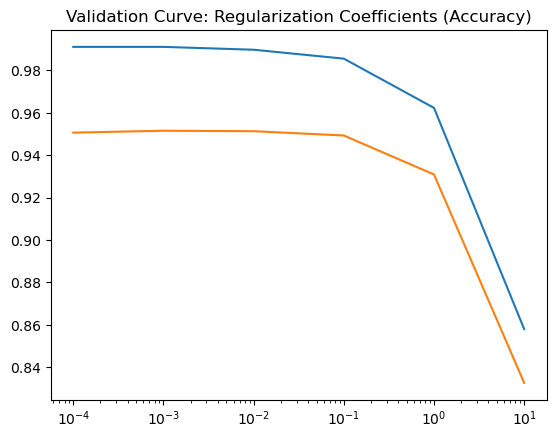

In [15]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=0)),
        ("clf", BernoulliNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (Accuracy)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

<h3><u>Findings From 'Regularization Coefficients' Accuracy Validation Curve</u></h3>
The plot suggests that the regularization coefficients will not help the generalization of the model since the scores are parallel to each other. On the other hand, the scores are very good especially when regularization is at its lowest. Therefore, a BernoulliNB model with a very low regularization coefficient is the best model to run in the cross-validation test.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.5s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    2.3s remaining:    2.3s


[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.4s finished


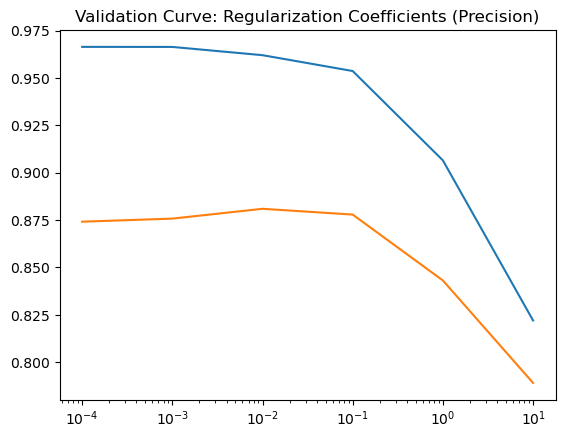

In [16]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=0)),
        ("clf", MultinomialNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train_transformed, cv=5, scoring='precision',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (Precision)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

<h3><u>Findings From 'Regularization Coefficients' Precision Validation Curve</u></h3>
The plot suggests that the regularization coefficients will not help the generalization of the model since the scores are parallel to each other. On the other hand, the scores are very good especially when regularization is at its lowest. Therefore, a BernoulliNB model with a very low regularization coefficient is the best model to run in the cross-validation test.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    2.3s remaining:    2.3s


[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.5s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.5s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.4s finished


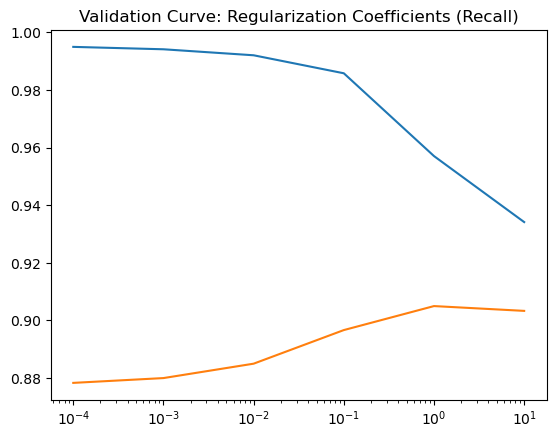

In [17]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=0)),
        ("clf", MultinomialNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train_transformed, cv=5, scoring='recall',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (Recall)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

<h3><u>Findings From 'Regularization Coefficients' Recall Validation Curve</u></h3>
The plot suggests that the regularization coefficients will not help the generalization of the model since the scores are parallel to each other. On the other hand, the scores are very good especially when regularization is at its lowest. Therefore, a BernoulliNB model with a very low regularization coefficient is the best model to run in the cross-validation test.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END ...................................clf__alpha=0.001; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    2.4s remaining:    2.4s


[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.5s
[CV] END .......................................clf__alpha=1; total time=   0.5s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.5s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished


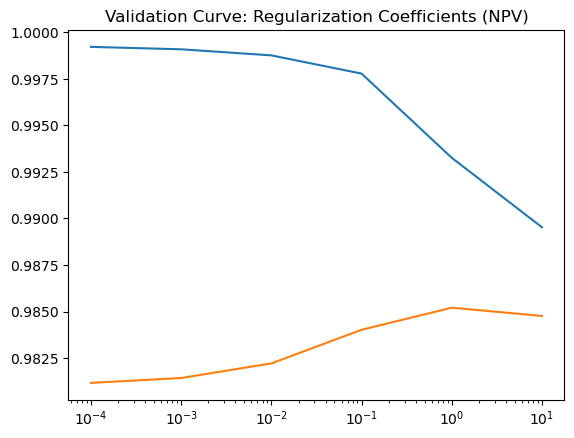

In [18]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=0)),
        ("clf", MultinomialNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train_transformed_rev, cv=5, scoring='precision',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (NPV)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

<h3><u>Findings From 'Regularization Coefficients' NPV Validation Curve</u></h3>
The plot suggests that the regularization coefficients will not help the generalization of the model since the scores are parallel to each other. On the other hand, the scores are very good especially when regularization is at its lowest. Therefore, a BernoulliNB model with a very low regularization coefficient is the best model to run in the cross-validation test.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    2.2s remaining:    2.2s


[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.5s
[CV] END ....................................clf__alpha=0.01; total time=   0.5s
[CV] END ...................................clf__alpha=0.001; total time=   0.5s
[CV] END .......................................clf__alpha=1; total time=   0.5s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.2s finished


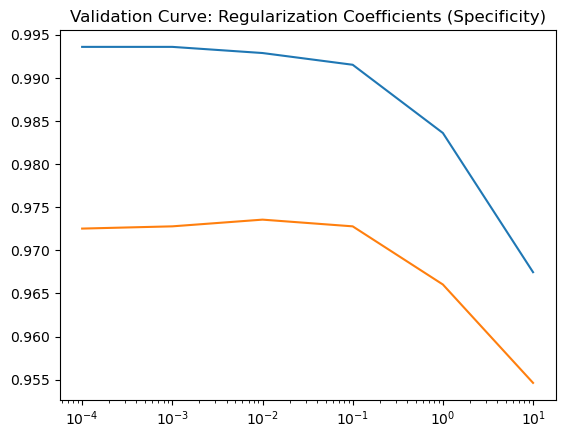

Exception ignored in: <function ResourceTracker.__del__ at 0x1048adbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1082edbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106e85bc0>
Traceback (most recent call last

In [19]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=0)),
        ("clf", MultinomialNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train_transformed_rev, cv=5, scoring='recall',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (Specificity)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

<h3><u>Findings From 'Regularization Coefficients' Specificity Validation Curve</u></h3>
The plot suggests that the regularization coefficients will not help the generalization of the model since the scores are parallel to each other. On the other hand, the scores are very good especially when regularization is at its lowest. Therefore, a BernoulliNB model with a very low regularization coefficient is the best model to run in the cross-validation test.

In [20]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=0)),
        ("clf", BernoulliNB())
    ]
) 
param_grid = {"clf__alpha": [0.009, 0.01, 0.03, 0.05, 0.1]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
nb_model = grid_search.best_estimator_
print(nb_model)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ....................................clf__alpha=0.01; total time=   2.8s
[CV] END ...................................clf__alpha=0.009; total time=   2.9s
[CV] END ....................................clf__alpha=0.01; total time=   2.9s
[CV] END ...................................clf__alpha=0.009; total time=   2.9s
[CV] END ...................................clf__alpha=0.009; total time=   2.9s
[CV] END ...................................clf__alpha=0.009; total time=   2.9s
[CV] END ...................................clf__alpha=0.009; total time=   2.9s
[CV] END ....................................clf__alpha=0.01; total time=   2.9s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END ....................................clf__alpha=0.03; total time=   0.7s
[CV] END ....................................clf_

<h3><u>Bayesian Training Learning Curves</u><h3>

In [27]:
clf_metrics = {'precision': 'NPV', 'recall': 'Specificity'}

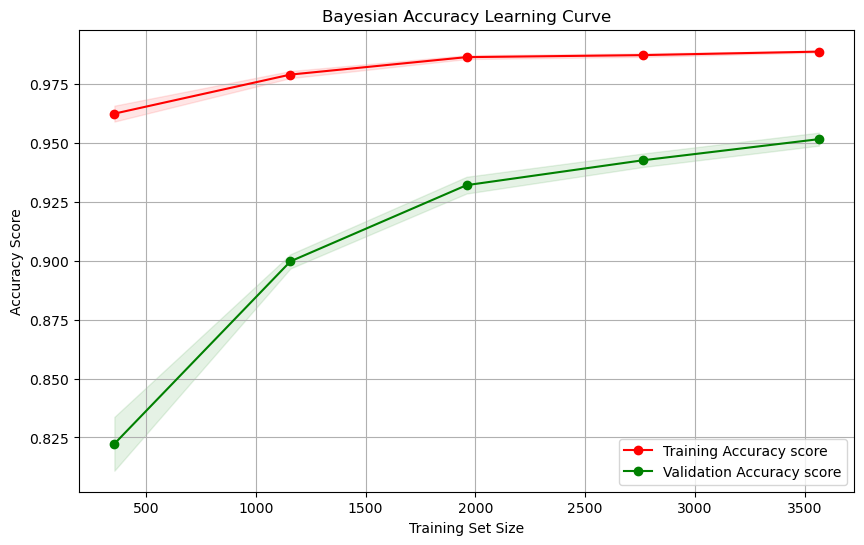

In [30]:
bayesian_train_sizes, bayesian_train_scores, bayesian_validation_scores = learning_curve(
    nb_model,
    X_train,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

# Calculate mean and standard deviation for scores
bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
bayesian_validation_scores_mean = np.mean(bayesian_validation_scores, axis=1)
bayesian_validation_scores_std = np.std(bayesian_validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title(f"Bayesian Accuracy Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel(f"Accuracy Score")
plt.grid()

plt.fill_between(bayesian_train_sizes, bayesian_train_scores_mean - bayesian_train_scores_std,
                bayesian_train_scores_mean + bayesian_train_scores_std, alpha=0.1,
                color="r")
plt.fill_between(bayesian_train_sizes, bayesian_validation_scores_mean - bayesian_validation_scores_std,
                bayesian_validation_scores_mean + bayesian_validation_scores_std, alpha=0.1,
                color="g")
plt.plot(bayesian_train_sizes, bayesian_train_scores_mean, 'o-', color="r",
            label=f"Training Accuracy score")
plt.plot(bayesian_train_sizes, bayesian_validation_scores_mean, 'o-', color="g",
            label=f"Validation Accuracy score")

plt.legend(loc="best")
plt.show()

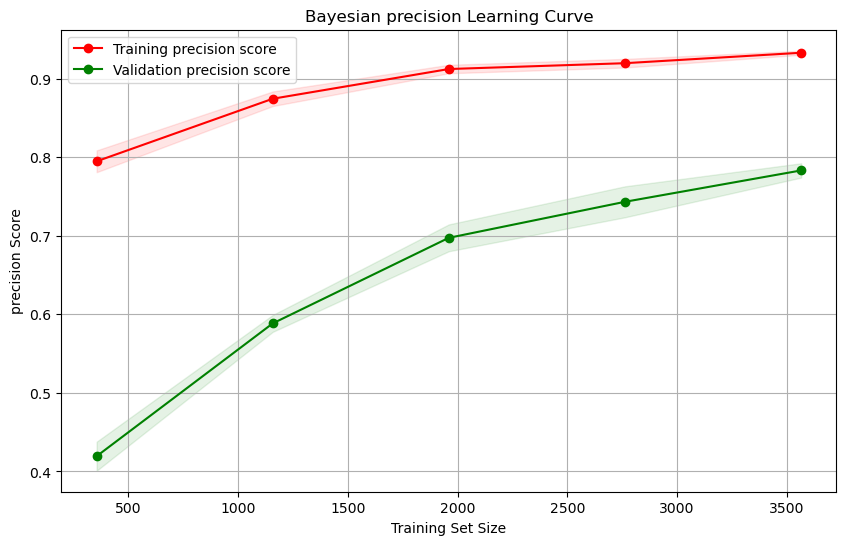

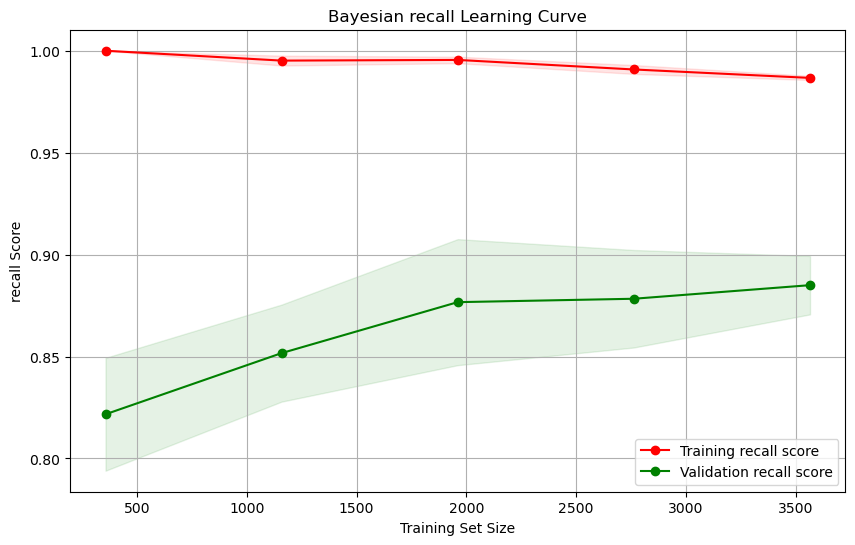

Exception ignored in: <function ResourceTracker.__del__ at 0x1058e5bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105141bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1096c5bc0>
Traceback (most recent call last

In [31]:
for key in clf_metrics:
    bayesian_train_sizes, bayesian_train_scores, bayesian_validation_scores = learning_curve(
        nb_model,
        X_train,
        y_train_transformed,
        cv=5,  # Number of folds for cross-validation
        scoring=key,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
    bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
    bayesian_validation_scores_mean = np.mean(bayesian_validation_scores, axis=1)
    bayesian_validation_scores_std = np.std(bayesian_validation_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title(f"Bayesian {key} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{key} Score")
    plt.grid()

    plt.fill_between(bayesian_train_sizes, bayesian_train_scores_mean - bayesian_train_scores_std,
                    bayesian_train_scores_mean + bayesian_train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(bayesian_train_sizes, bayesian_validation_scores_mean - bayesian_validation_scores_std,
                    bayesian_validation_scores_mean + bayesian_validation_scores_std, alpha=0.1,
                    color="g")
    plt.plot(bayesian_train_sizes, bayesian_train_scores_mean, 'o-', color="r",
                label=f"Training {key} score")
    plt.plot(bayesian_train_sizes, bayesian_validation_scores_mean, 'o-', color="g",
                label=f"Validation {key} score")

    plt.legend(loc="best")
    plt.show()

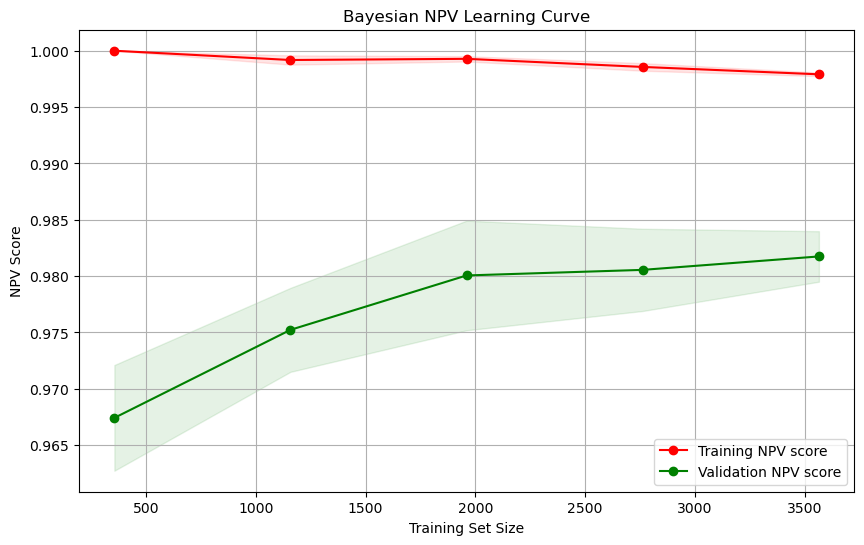

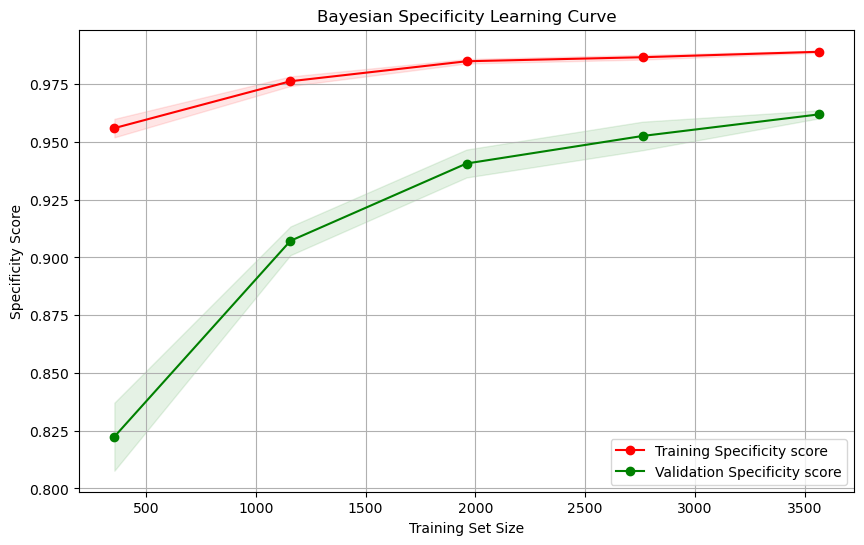

In [29]:
for key, value in clf_metrics.items():
    bayesian_train_sizes, bayesian_train_scores, bayesian_validation_scores = learning_curve(
        nb_model,
        X_train,
        y_train_transformed_rev,
        cv=5,  # Number of folds for cross-validation
        scoring=key,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
    bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
    bayesian_validation_scores_mean = np.mean(bayesian_validation_scores, axis=1)
    bayesian_validation_scores_std = np.std(bayesian_validation_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title(f"Bayesian {value} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{value} Score")
    plt.grid()

    plt.fill_between(bayesian_train_sizes, bayesian_train_scores_mean - bayesian_train_scores_std,
                    bayesian_train_scores_mean + bayesian_train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(bayesian_train_sizes, bayesian_validation_scores_mean - bayesian_validation_scores_std,
                    bayesian_validation_scores_mean + bayesian_validation_scores_std, alpha=0.1,
                    color="g")
    plt.plot(bayesian_train_sizes, bayesian_train_scores_mean, 'o-', color="r",
                label=f"Training {value} score")
    plt.plot(bayesian_train_sizes, bayesian_validation_scores_mean, 'o-', color="g",
                label=f"Validation {value} score")

    plt.legend(loc="best")
    plt.show()

<h2><strong><u>Metrics</u></strong></h2>

<h3><u>Bayesian Training Results<u></h3>

In [21]:
#Cross-Validation Loop

nb_training_values = cross_val_score(nb_model, X_train, y_train, scoring='accuracy', cv=5)
print("Cross-validation Accuracy training scores: ", nb_training_values)
np_nb_training_values = np.array(nb_training_values)
average = np.mean(np_nb_training_values)
stDev = np.std(np_nb_training_values)
print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.95067265 0.94730942 0.95510662 0.95398429 0.95061728]
0.95  +/-  0.0028 



In [24]:
for key in clf_metrics:
    nb_training_values = cross_val_score(nb_model, X_train, y=y_train_transformed, scoring=key, cv=5)
    print(f"Cross-validation {key} training scores: ", nb_training_values)
    np_nb_training_values = np.array(nb_training_values)
    average = np.mean(np_nb_training_values)
    stDev = np.std(np_nb_training_values)
    print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation precision training scores:  [0.77941176 0.77037037 0.79850746 0.78417266 0.78358209]
0.78  +/-  0.0091 

Cross-validation recall training scores:  [0.88333333 0.86666667 0.89166667 0.90833333 0.875     ]
0.88  +/-  0.0143 



In [ ]:
for key, value in clf_metrics.items():
    nb_training_values = cross_val_score(nb_model, X_train, y=y_train_transformed_rev, scoring=key, cv=5)
    print(f"Cross-validation {value} training scores: ", nb_training_values)
    np_nb_training_values = np.array(nb_training_values)
    average = np.mean(np_nb_training_values)
    stDev = np.std(np_nb_training_values)
    print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation NPV training scores:  [0.98148148 0.97886394 0.98282695 0.98537234 0.98018494]
0.98  +/-  0.0022 

Cross-validation Specificity training scores:  [0.9611399  0.95984456 0.96498054 0.96108949 0.96238651]
0.96  +/-  0.0017 



Exception ignored in: <function ResourceTracker.__del__ at 0x102a19bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102fd9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102de5bc0>
Traceback (most recent call last

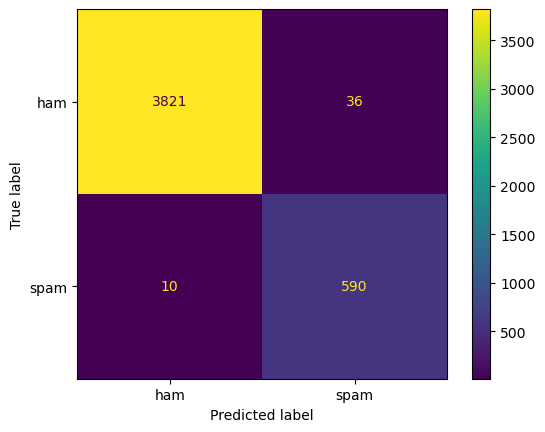

In [11]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(nb_model, X_train, y_train)

In [26]:
train_predictions = nb_model.predict(X_train)
nb_train_precision = precision_score(y_train, train_predictions, pos_label='spam')
print("Naive Bayes Training Precision: {:.2f}%".format(nb_train_precision * 100))

nb_train_recall = recall_score(y_train, train_predictions, pos_label='spam')
print("Naive Bayes Training Recall: {:.2f}%".format(nb_train_recall * 100))

nb_train_npv = precision_score(y_train, train_predictions, pos_label='ham')
print("Naive Bayes Negative Predictive Value Training Score: {:.2f}%".format(nb_train_npv * 100))

nb_train_specificity = recall_score(y_train, train_predictions, pos_label='ham')
print("Naive Bayes Specificity Training Score: {:.2f}%".format(nb_train_specificity * 100))

Naive Bayes Training Precision: 94.25%
Naive Bayes Training Recall: 98.33%
Naive Bayes Negative Predictive Value Training Score: 99.74%
Naive Bayes Specificity Training Score: 99.07%


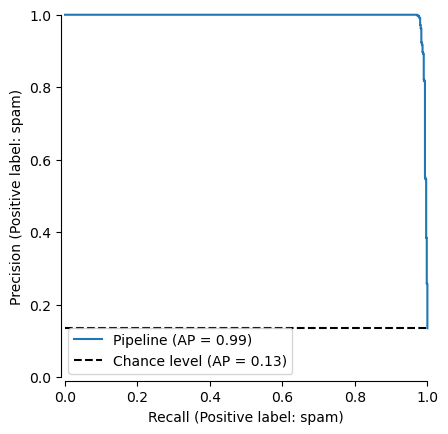

In [ ]:
PrecisionRecallDisplay.from_estimator(nb_model, X_train, y_train, pos_label="spam", plot_chance_level=True, despine=True)

<h3><u>Bayesian Testing Results</u></h3>

In [ ]:
test_predictions = nb_model.predict(X_test)

nb_test_accuracy = accuracy_score(y_test, test_predictions)
print("Naive Bayes Test Accuracy: {:.2f}%".format(nb_test_accuracy * 100))

nb_test_precision = precision_score(y_test, test_predictions, pos_label='spam')
print("Naive Bayes Test Precision: {:.2f}%".format(nb_test_precision * 100))

nb_test_recall = recall_score(y_test, test_predictions, pos_label='spam')
print("Naive Bayes Test Recall: {:.2f}%".format(nb_test_recall * 100))

nb_test_npv = precision_score(y_test, test_predictions, pos_label='ham')
print("Naive Bayes Negative Predictive Value Test Score: {:.2f}%".format(nb_test_npv * 100))

nb_test_specificity = recall_score(y_test, test_predictions, pos_label='ham')
print("Naive Bayes Specificity Test Score: {:.2f}%".format(nb_test_specificity * 100))

Naive Bayes Test Accuracy: 96.68%
Naive Bayes Test Precision: 83.54%
Naive Bayes Test Recall: 93.20%
Negative Predictive Value Score: 93.20%
Specificity Score: 93.20%


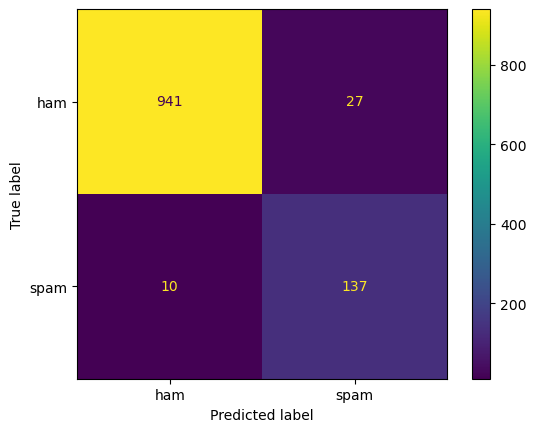

Exception ignored in: <function ResourceTracker.__del__ at 0x104331bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107331bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102af1bc0>
Traceback (most recent call last

In [15]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)